# CNN - Transfer Learning

Test VGG16 vs EfficientNet

## Import modules

In [16]:
import time
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input

## Define directories

In [ ]:
## For use local machine
# import os
# project_path='.../Covid19/raw_data/cloud/train_test/'
# train_dir = os.path.join(project_path, 'train')
# test_dir = os.path.join(project_path, 'test')

In [4]:
## For use Google Colab (mount Google Drive)
drive.mount('/content/drive')
project_path="/content/drive/MyDrive/train_test"
train_dir = f"{project_path}/train"
test_dir = f"{project_path}/test"

Mounted at /content/drive


## Create Generators

https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

### Versão antiga

In [31]:
#from tensorflow.keras.preprocessing import image_dataset_from_directory

# train_generator = image_dataset_from_directory(train_dir,
#                                                labels="inferred",
#                                                color_mode='grayscale',
#                                                batch_size = 32,
#                                                image_size=(224,224),
#                                                seed=42,
#                                                label_mode = "categorical",
#                                                validation_split=0.2,
#                                                subset = "training")

# validation_generator = image_dataset_from_directory(train_dir,
#                                                labels="inferred",
#                                                color_mode='grayscale',
#                                                batch_size = 32,
#                                                image_size=(224,224),
#                                                seed=42,
#                                                label_mode = "categorical",
#                                                validation_split=0.2,
#                                                subset = "validation")

# test_generator = image_dataset_from_directory(test_dir,
#                                               labels="inferred",
#                                               batch_size = 32,
#                                               color_mode='grayscale',
#                                               image_size=(224,224),
#                                               seed=42,
#                                               label_mode = "categorical")

Found 13648 files belonging to 4 classes.
Using 10919 files for training.
Found 13648 files belonging to 4 classes.
Using 2729 files for validation.
Found 14 files belonging to 4 classes.


### Nova versão

In [8]:
"""
Result a generator with shape (150,150,3)
"""
# Create a generator with augmentation for training and validation:
dgen_train = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2,
                                shear_range=0.2,
                                zoom_range = 0.2,
                                horizontal_flip = False)

# Create a generator without augmentation for test:
dgen_test = ImageDataGenerator(rescale=1./255)

# Make generators by directories:
# The classes wiil be the subdirectories
train_generator = dgen_train.flow_from_directory(train_dir,
                                                target_size=(150,150),
                                                subset = "training",
                                                batch_size = 32,
                                                class_mode = "categorical")

validation_generator = dgen_train.flow_from_directory(train_dir,
                                                target_size=(150,150),
                                                subset = "validation",
                                                batch_size = 32,
                                                class_mode = "categorical")

test_generator = dgen_test.flow_from_directory(test_dir,
                                                target_size=(150,150),
                                                batch_size = 32,
                                                class_mode = "categorical")



Found 16183 images belonging to 4 classes.
Found 4044 images belonging to 4 classes.
Found 5059 images belonging to 4 classes.


In [11]:
train_generator.image_shape

(150, 150, 3)

## Test a Simple CNN model

In [32]:
def load_own_model(input_shape):

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=input_shape))

    model.add(layers.Conv2D(16, kernel_size=16, activation='relu'))
    model.add(layers.AveragePooling2D(4))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.AveragePooling2D(4))
    model.add(layers.Dropout(0.3))

    # model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    # model.add(layers.MaxPooling2D(4))
    # model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(4, activation='softmax'))

    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [33]:
model_homemade = load_own_model(input_shape=train_generator.image_shape)
model_homemade.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 1)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 215, 215, 16)      1616      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 53, 53, 16)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 53, 53, 16)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 46, 46, 32)        32800     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 11, 11, 32)        0         
 g2D)                                                 

In [36]:
model_homemade.evaluate(test_generator)

1/1 [==============================] - 2s 2s/step - loss: 3.2669 - accuracy: 0.0000e+00


[3.2669475078582764, 0.0]

In [ ]:
history.history

In [20]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='validation' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='validation'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

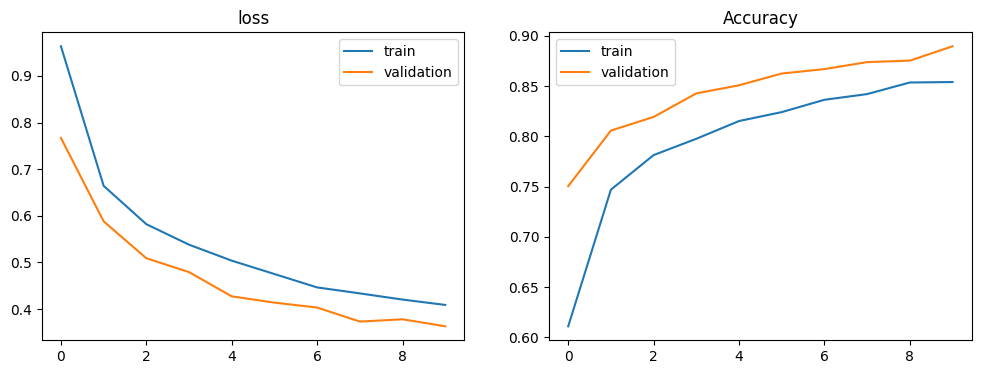

In [48]:
plot_history(history);

## Test VGG16

## Test EfficientNet

In [12]:
#preproc_layer = preprocess_input(train_generator)
base_model = EfficientNetB7(input_shape = train_generator.image_shape, include_top = False, weights = 'imagenet')
base_model.trainable = False
pooling_layer = layers.MaxPooling2D()
flatten_layer = layers.Flatten()
dense_layer = layers.Dense(32, activation='relu')
dense_layer = layers.Dense(32, activation='relu')
dropout_layer = layers.Dropout(0.2)
prediction_layer = layers.Dense(4, activation='softmax')

efficient = models.Sequential([
        #preproc_layer,
        base_model,
        pooling_layer,
        flatten_layer,
        dense_layer,
        dropout_layer,
        prediction_layer
    ])

258076736/258076736 [==============================] - 1s 0us/step


In [13]:
efficient.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])

In [14]:
es = EarlyStopping(monitor = 'val_loss',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

In [17]:
start = time.perf_counter()
history = efficient.fit(train_generator,
                        batch_size = 32,
                        validation_data=validation_generator,
                        epochs = 20,
                        callbacks=[es])
end = time.perf_counter()
print(f"\n✅ Total time: ({round(end - start, 2)}s)")

Epoch 1/10
506/506 [==============================] - 5497s 11s/step - loss: 1.3453 - accuracy: 0.3753 - val_loss: 1.3256 - val_accuracy: 0.4031
Epoch 2/10
506/506 [==============================] - 3108s 6s/step - loss: 1.3399 - accuracy: 0.3803 - val_loss: 1.3345 - val_accuracy: 0.4031
Epoch 3/10
506/506 [==============================] - 3098s 6s/step - loss: 1.3405 - accuracy: 0.4022 - val_loss: 1.3505 - val_accuracy: 0.4031
Epoch 4/10
506/506 [==============================] - 3128s 6s/step - loss: 1.3456 - accuracy: 0.4031 - val_loss: 1.3370 - val_accuracy: 0.4031
Epoch 5/10
506/506 [==============================] - 3105s 6s/step - loss: 1.3444 - accuracy: 0.4031 - val_loss: 1.3317 - val_accuracy: 0.4031
Epoch 6/10
506/506 [==============================] - 3093s 6s/step - loss: 1.3367 - accuracy: 0.4031 - val_loss: 1.3264 - val_accuracy: 0.4031
Epoch 6: early stopping

✅ Total time: (21073.13s)


In [18]:
efficient.evaluate(test_generator)

159/159 [==============================] - 1573s 10s/step - loss: 1.3241 - accuracy: 0.4030


[1.3241044282913208, 0.40304407477378845]

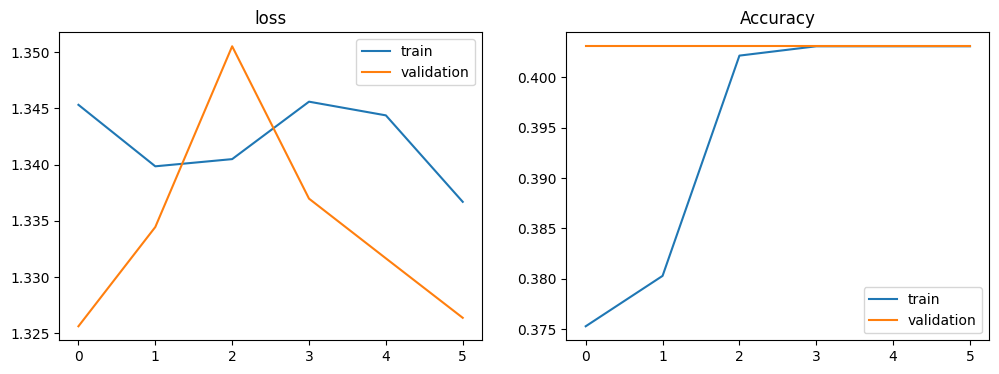

In [21]:
plot_history(history);